In [36]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
%matplotlib inline

In [37]:
df = pd.read_csv('main_dataset.csv')
test_df = pd.read_csv('exp_test.csv')

In [38]:
df

index     author                                               text  ai_label
0       1  John Nery  The success of the Marcos-Duterte electoral al...         0
1       2  John Nery  The war on Ninoy Aquino’s legacy is a fight th...         0
2       3  John Nery  One of many lessons from the ongoing Twitter f...         0
3       4  John Nery  Of course we all need to be particular about t...         0
4       5  John Nery  In 'Some People Need Killing,' the acclaimed j...         0
..    ...        ...                                                ...       ...
95     96    Copilot  The concept of federalism has been a recurring...         1
96     97    Copilot  Election campaign finance transparency is a co...         1
97     98    Copilot  Mental health stigma remains a significant bar...         1
98     99    Copilot  Urban congestion and housing shortages are two...         1
99    100    Copilot  Plastic pollution is a critical environmental ...         1

[100 rows x 4 columns]

In [39]:
#test_df

In [40]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

# Apply preprocessing and feature extraction to each text sample
def preprocess_and_extract_features(df):
    df['preprocessed_text'] = df['text'].apply(preprocess_text)
    df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
    return pd.concat([df[['index', 'label']], df_features], axis=1)

In [41]:
#Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [42]:
# Model training
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [43]:
# Model Preparation
X_test = test_df.drop(['index', 'label'], axis=1)
y_test = test_df['label']

In [44]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [45]:
# Function to extract features and store them into a DataFrame
def extract_features_as_df(text):
    # Call the existing extract_features function
    raw_features = extract_features(text)
    
    # Convert the features to a DataFrame with two columns: Feature and Value
    features_df = pd.DataFrame(list(raw_features.items()), columns=['Feature', 'Value'])
    
    return features_df

def extract_features_for_csv(df):
    feature_dfs = df['text'].apply(extract_features_as_df)
    
    # Concatenate all the feature DataFrames into a single DataFrame
    all_features = pd.concat(feature_dfs.tolist(), ignore_index=True)
    
    # Concatenate the extracted features with the original DataFrame
    df_features = pd.concat([df, all_features], axis=1)
    
    # Remove rows with any NaN values
    df_features_cleaned = df_features.dropna()
    
    return df_features_cleaned

df_features = extract_features_for_csv(df)
df_features

index     author                                               text  ai_label                                  preprocessed_text  word_count  sentence_count  avg_word_length  avg_sentence_length  punctuation_count  punctuation_ratio  avg_punctuation_per_sentence  vocab_size  vocab_ratio  flesch_reading_ease  gunning_fog  smog_index  coleman_liau_index  avg_clauses_per_sentence  complex_sentence_ratio  lexical_density              Feature        Value
0     1.0  John Nery  The success of the Marcos-Duterte electoral al...       0.0  the success of the marcos-duterte electoral al...      1558.0            65.0         4.835045            23.969231              179.0           0.114891                      2.753846       610.0     0.391528                47.32        13.13        13.8               11.78                  2.000000                0.523077         0.620668           word_count  1558.000000
1     2.0  John Nery  The war on Ninoy Aquino’s legacy is a fight th...       0.0  the war on ninoy aquino’s legacy is a fight th...      1475.0            56.0         4.792542            26.339286              174.0           0.117966                      3.107143       584.0     0.395932                54.66        13.13        13.4               11.09                  2.589286                0.625000         0.608136       sentence_count    68.000000
2     3.0  John Nery  One of many lessons from the ongoing Twitter f...       0.0  one of many lessons from the ongoing twitter f...       851.0            39.0         4.659224            21.820513              117.0           0.137485                      3.000000       386.0     0.453584                67.28        11.03        11.1               10.21                  2.256410                0.487179         0.642773      avg_word_length     4.835045
3     4.0  John Nery  Of course we all need to be particular about t...       0.0  of course we all need to be particular about t...       996.0            40.0         4.618474            24.900000              109.0           0.109438                      2.725000       390.0     0.391566                57.20        12.12        13.1               10.51                  2.175000                0.600000         0.648594  avg_sentence_length    22.911765
4     5.0  John Nery  In 'Some People Need Killing,' the acclaimed j...       0.0  in 'some people need killing,' the acclaimed j...      1800.0            73.0         4.695000            24.657534              274.0           0.152222                      3.753425       724.0     0.402222                59.53        11.04        11.8               10.68                  2.808219                0.561644         0.655000    punctuation_count   179.000000
..    ...        ...                                                ...       ...                                                ...         ...             ...              ...                  ...                ...                ...                           ...         ...          ...                  ...          ...         ...                 ...                       ...                     ...              ...                  ...          ...
95   96.0    Copilot  The concept of federalism has been a recurring...       1.0  the concept of federalism has been a recurring...       734.0            42.0         6.156676            17.476190              101.0           0.137602                      2.404762       307.0     0.418256                19.37        13.24        16.2               18.62                  1.833333                0.547619         0.656676      lexical_density     0.636925
96   97.0    Copilot  Election campaign finance transparency is a co...       1.0  election campaign finance transparency is a co...       756.0            41.0         6.203704            18.439024              112.0           0.148148                      2.731707       317.0     0.419312                18.86        14.14       

In [46]:
# Feature normalization ranges
feature_ranges = {
    'word_count': (0, 10000),  # Adjust as needed
    'sentence_count': (0, 1000),  # Adjust as needed
    'avg_word_length': (1, 10),  # Average word length typically ranges from 1 to 10 characters
    'avg_sentence_length': (0, 100),  # Average sentence length in words
    'punctuation_count': (0, 1000),  # Total punctuation marks, adjust as needed
    'punctuation_ratio': (0, 1),  # Ratio of punctuation marks per character
    'avg_punctuation_per_sentence': (0, 10),  # Adjust based on expected punctuation per sentence
    'vocab_size': (0, 1000),  # Vocabulary size, adjust as needed
    'vocab_ratio': (0, 1),  # Vocabulary ratio
    'flesch_reading_ease': (0, 100),  # Flesch reading ease score
    'gunning_fog': (6, 17),  # Gunning-Fog Index
    'smog_index': (6, 17),  # SMOG Index
    'coleman_liau_index': (5, 17),  # Coleman-Liau Index
    'avg_clauses_per_sentence': (0, 10),  # Average number of clauses per sentence
    'complex_sentence_ratio': (0, 1),  # Ratio of complex sentences
    'lexical_density': (0, 1)  # Lexical density
}

def normalize_feature(value, feature_name, feature_ranges):
    """Normalize a single feature value based on its predefined range."""
    if feature_name in feature_ranges:
        min_val, max_val = feature_ranges[feature_name]
        if max_val - min_val == 0:  # Avoid division by zero
            return 0
        return (value - min_val) / (max_val - min_val)
    else:
        raise ValueError(f"Feature '{feature_name}' does not have defined normalization ranges.")

def extract_and_normalize_features_as_df(text, feature_ranges):
    """Extract features, normalize them, and return as a DataFrame with normalized columns."""
    # Extract features into a DataFrame
    features_df = extract_features_as_df(text)

    # Check for empty or missing data
    if features_df.empty:
        print("No features extracted for the text. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame for consistency

    # Create a dictionary to store normalized values
    normalized_data = {}

    for _, row in features_df.iterrows():
        feature_name = row['Feature']
        raw_value = row['Value']

        if feature_name in feature_ranges:
            # Normalize the feature value and add it as a new column
            normalized_data[f"{feature_name}_normalized"] = normalize_feature(raw_value, feature_name, feature_ranges)
        else:
            print(f"Feature '{feature_name}' not found in feature_ranges. Skipping normalization.")

    # Convert normalized data to a DataFrame
    normalized_df = pd.DataFrame([normalized_data])
    return normalized_df

def extract_and_normalize_features_for_csv(df, feature_ranges):
    """Extract and normalize features for the entire dataset."""
    # Initialize a list to store normalized DataFrames for each text
    normalized_dfs = []

    for text in df['text']:
        normalized_df = extract_and_normalize_features_as_df(text, feature_ranges)
        normalized_dfs.append(normalized_df)

    # Concatenate all normalized DataFrames into a single DataFrame
    all_normalized_features = pd.concat(normalized_dfs, ignore_index=True)

    # Add the normalized columns to the original DataFrame
    df_features = pd.concat([df.reset_index(drop=True), all_normalized_features.reset_index(drop=True)], axis=1)

    # Drop rows with NaN values if any normalized feature is missing
    df_features_cleaned = df_features.dropna()

    return df_features_cleaned

In [47]:
# Extract and normalize features for the dataset
df_normalized_features = extract_and_normalize_features_for_csv(df, feature_ranges)

# Display the normalized DataFrame
df_normalized_features

index     author                                               text  ai_label                                  preprocessed_text  word_count  sentence_count  avg_word_length  avg_sentence_length  punctuation_count  punctuation_ratio  avg_punctuation_per_sentence  vocab_size  vocab_ratio  flesch_reading_ease  gunning_fog  smog_index  coleman_liau_index  avg_clauses_per_sentence  complex_sentence_ratio  lexical_density  word_count_normalized  sentence_count_normalized  avg_word_length_normalized  avg_sentence_length_normalized  punctuation_count_normalized  punctuation_ratio_normalized  avg_punctuation_per_sentence_normalized  vocab_size_normalized  vocab_ratio_normalized  flesch_reading_ease_normalized  gunning_fog_normalized  smog_index_normalized  coleman_liau_index_normalized  avg_clauses_per_sentence_normalized  complex_sentence_ratio_normalized  lexical_density_normalized
0       1  John Nery  The success of the Marcos-Duterte electoral al...         0  the success of the marcos-duterte electoral al...      1558.0            65.0         4.835045            23.969231              179.0           0.114891                      2.753846       610.0     0.391528                47.32        13.13        13.8               11.78                  2.000000                0.523077         0.620668                 0.1558                      0.068                    0.426116                        0.229118                         0.179                      0.114891                                 0.263235                  0.644                0.413350                          0.4732                0.648182               0.709091                       0.565000                             0.191176                           0.529412                    0.616816
1       2  John Nery  The war on Ninoy Aquino’s legacy is a fight th...         0  the war on ninoy aquino’s legacy is a fight th...      1475.0            56.0         4.792542            26.339286              174.0           0.117966                      3.107143       584.0     0.395932                54.66        13.13        13.4               11.09                  2.589286                0.625000         0.608136                 0.1475                      0.056                    0.421394                        0.263393                         0.174                      0.117966                                 0.310714                  0.615                0.416949                          0.5466                0.648182               0.672727                       0.507500                             0.258929                           0.625000                    0.604746
2       3  John Nery  One of many lessons from the ongoing Twitter f...         0  one of many lessons from the ongoing twitter f...       851.0            39.0         4.659224            21.820513              117.0           0.137485                      3.000000       386.0     0.453584                67.28        11.03        11.1               10.21                  2.256410                0.487179         0.642773                 0.0851                      0.040                    0.406580                        0.212750                         0.117                      0.137485                                 0.292500                  0.409                0.480611                          0.6728                0.457273               0.463636                       0.434167                             0.220000                           0.475000                    0.643948
3       4  John Nery  Of course we all need to be particular about t...         0  of course we all need to be particular about t...       996.0            40.0         4.618474            24.900000              109.0           0.109438                      2.725000       390.0     0.391566                57.20        12.12        13.1               10.51                  2.175000                0.600000         0.648594        

In [48]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [49]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [50]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [60]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)

    print(f"Provided Author: {author}")
    print(f"Predicted Author: {predicted_author}")
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis. Predicted author is: '{predicted_author}'")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)

    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
        # 'readability': ['flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index'],
        # 'complexity': ['complex_sentence_ratio']
    }

    explanations = []
    changepoint_data = [] #List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    total_changes = {category: 0 for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                # Only include positive changes
                if change > 0:  # Process only non-zero changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,  # Always non-negative
                            'Category': category
                        })
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
       
           
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    if not changepoint_df.empty:  # Check if the DataFrame is non-empty
        average_changes = (
            changepoint_df.groupby('Category')['Change Value']
            .mean()
            .reset_index()
            .rename(columns={'Change Value': 'Average Change Value'})
        )
        
        print("\n--- Average Normalized Change Value by Category ---")
        print(average_changes)
    else:
        print("No change points detected; no averages to calculate.") 
    # Display summary of changes by category
    # print("\n--- Percentage of Change by Category ---")
    # total_sentences = len(sentences)
    # for category, sentence_indices in category_changes.items():
    #     unique_changes = len(sentence_indices)
    #     category_percentage = (unique_changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")
    print("\n")
    # Display results similarly
    for explanation in explanations:
        print(f"Change detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=[
            'Feature', 'Change Value', 'Category'
        ])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")

    # print("\n--- Percentage of Change by Category ---")
    # for category, changes in category_changes.items():
    #     total_sentences = len(sentences)
    #     category_percentage = (changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")

    return changepoints, explanations, changepoint_df


In [61]:
def detect_change_points_in_text_with_normalization(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features_df = extract_features_as_df(preprocess_text(new_text))
    
    # Normalize the feature values
    normalized_features_df = normalize_features(features_df)
    
    print("Features with Normalized Values:")
    display(normalized_features_df)
    
    # Use normalized values in further computations
    normalized_features = normalized_features_df['Normalized Value'].values
    
    # Perform changepoint detection using normalized features
    # (Insert the existing BOCPD changepoint detection logic here)
    # Ensure all calculations use the normalized_features array

    return normalized_features_df


Provided Author: Maria A. Ressa
Predicted Author: ['Maria A. Ressa']

--- Average Normalized Change Value by Category ---
               Category  Average Change Value
0  Linguistic Diversity              0.224880
1           Phraseology              0.131737
2           Punctuation              0.116087


Change detected in sentence: Ressa, chief executive officer of Rappler, was a keynote speaker at the Jubilee of the World of Communications organized by the Vatican’s Dicastery for Communication.
Feature changes:


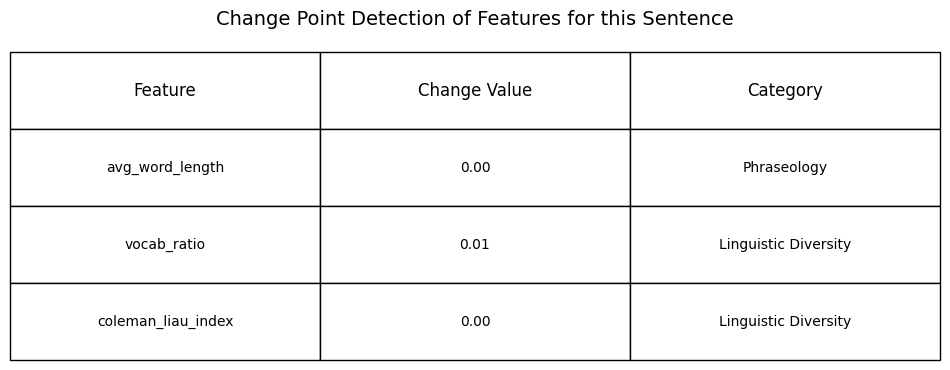

Change detected in sentence: The other speaker was Irish journalist Colum McCann.
Feature changes:


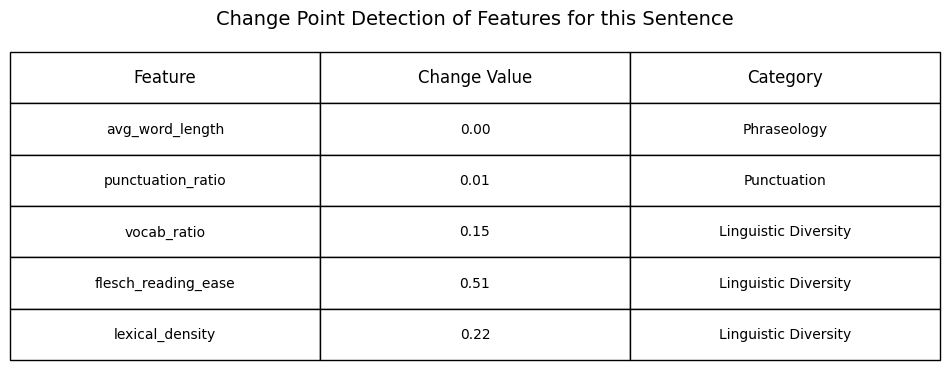

Change detected in sentence: “Even at the worst of times, hope is not passive; it is active, relentless, and strategic.
Feature changes:


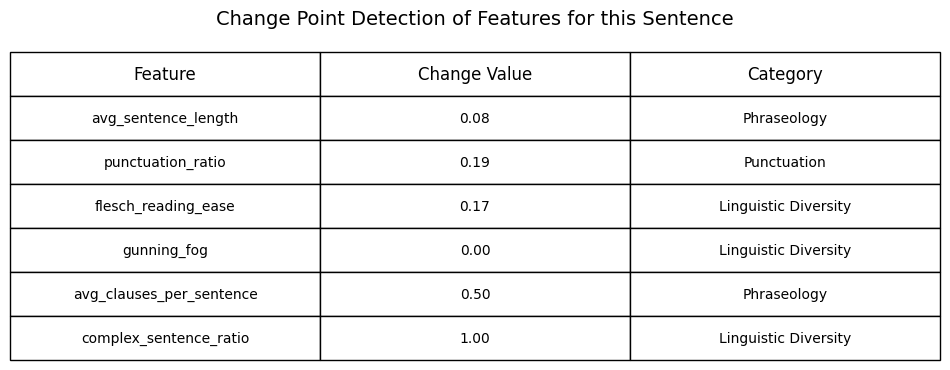

Change detected in sentence: “Imagine if we all worked together.
Feature changes:


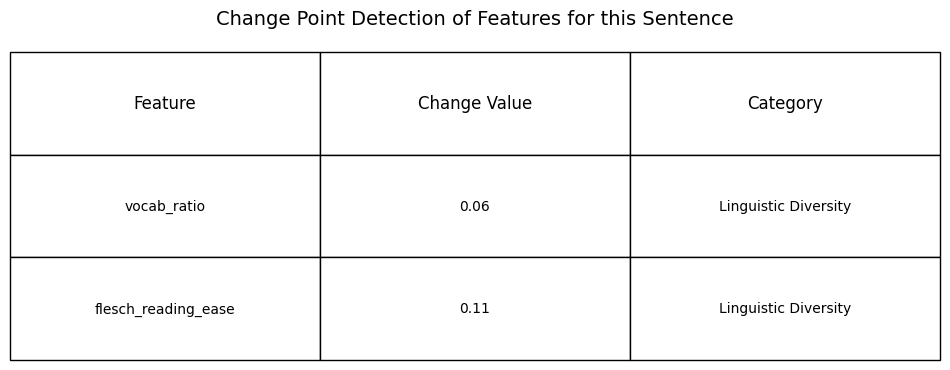

Change detected in sentence: We just might stem the tide, stop the dam from falling, and heal our world,” said the 61-year-old Filipino-American journalist.
Feature changes:


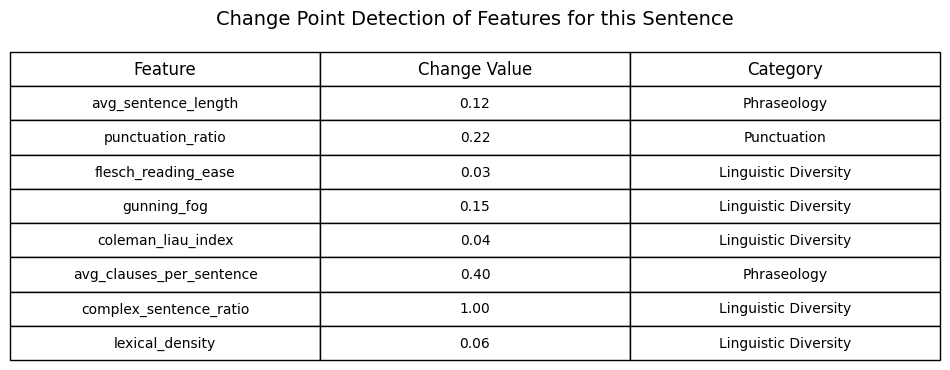

Change detected in sentence: The crowd — composed of thousands of Catholic communicators around the world — gave her a standing ovation.
Feature changes:


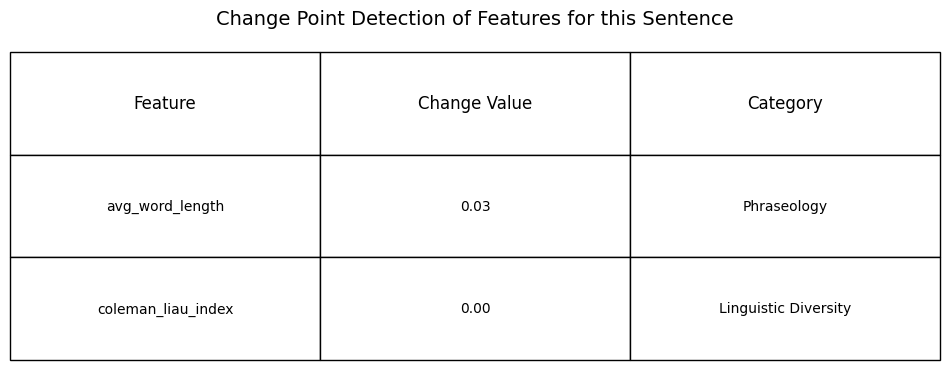

Change detected in sentence: Saturday’s event was held at the Vatican’s 6,300-seater Paul VI Audience Hall, the iconic venue for Pope Francis‘ indoor general audiences.
Feature changes:


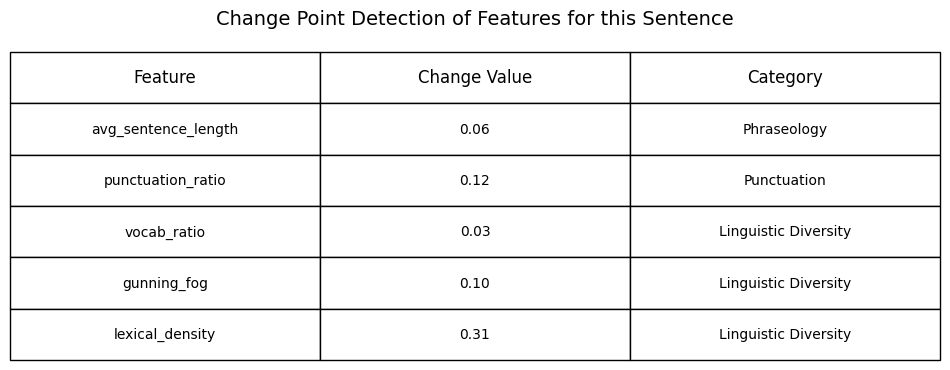

Change detected in sentence: Standing at 5 feet and 2 inches, Ressa addressed the crowd against the backdrop of a renowned bronze sculpture of Jesus — 66 feet wide and 23 feet tall — inspired by the atomic bombing of Hiroshima, Japan, in 1945.
Feature changes:


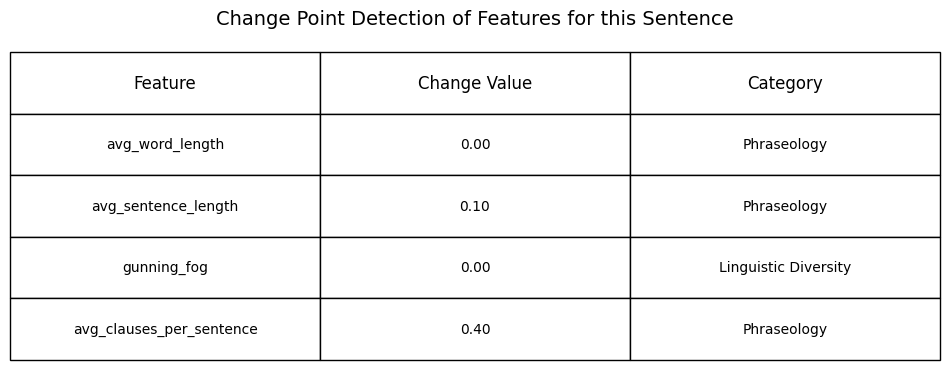

Change detected in sentence: Titled “Resurrection” and inaugurated nearly 50 years ago, the sculpture resembles an explosion and symbolizes Christ’s victory over death.
Feature changes:


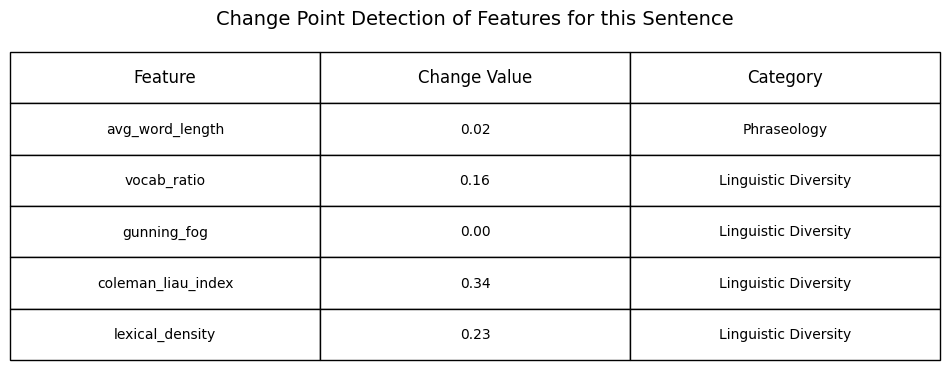

Change detected in sentence: Ressa recalled the Hiroshima bombing in her speech on Saturday in the context of how “new technology enabled the rise of fascism.”

“For many years now, I’ve sounded the alarm: just like in Hiroshima, an atom bomb exploded in our information ecosystem,” she said.
Feature changes:


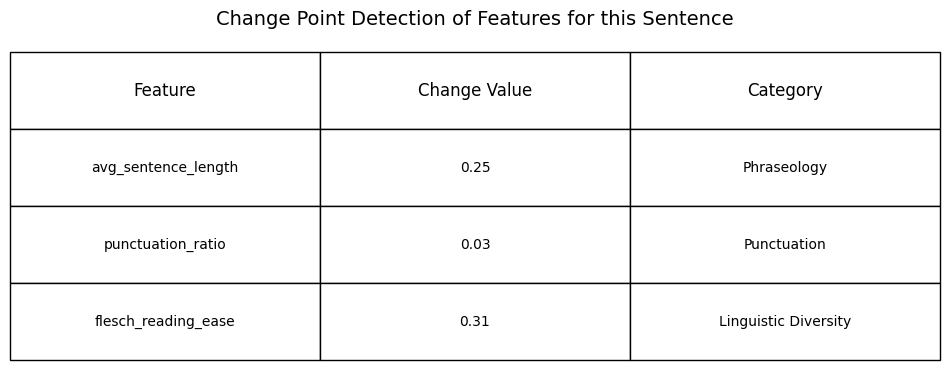

Change detected in sentence: “In pursuit of power and money, technology enabled insidious manipulation at the cellular level of all of our democracies: of us — the voters — microtargeting fear, anger, and hate; seeding metanarratives that destroyed trust,” she said.
Feature changes:


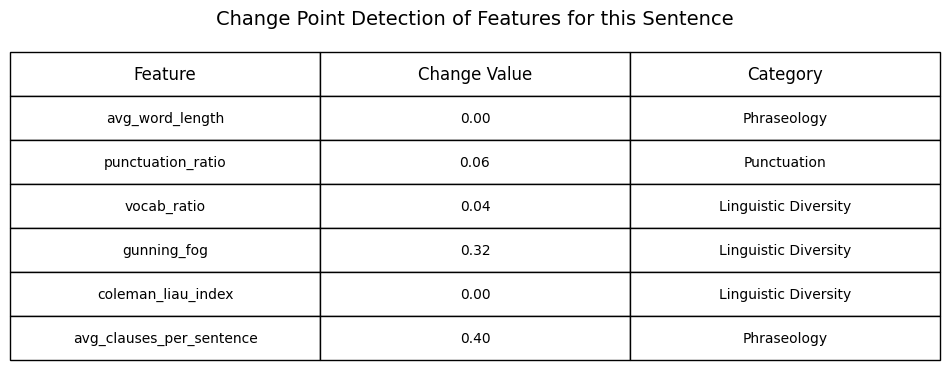

Change detected in sentence: She remembered telling Pope Francis that the way technology “rewards lies” is against the Ten Commandments.
Feature changes:


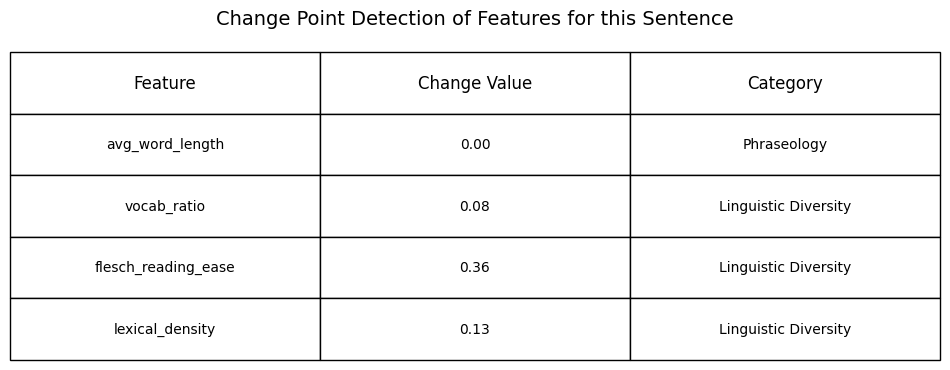

Change detected in sentence: “The men who control this transformative technology wield godlike power, but they’re far from God.
Feature changes:


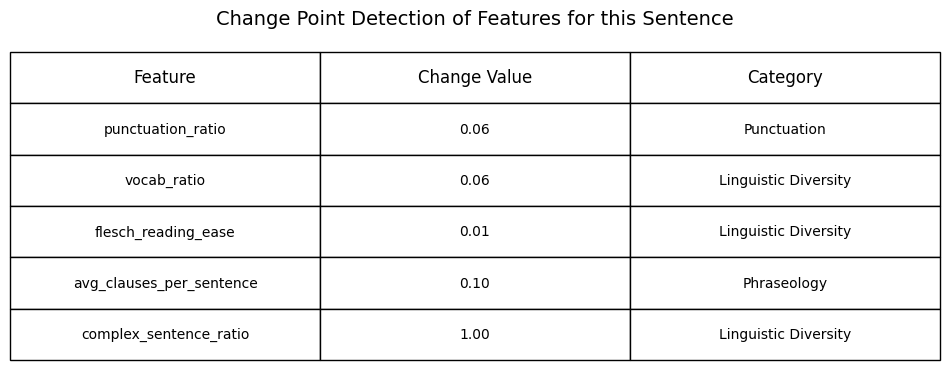

Change detected in sentence: Ressa offered four suggestions:

Collaborate, collaborate, collaborate.
Feature changes:


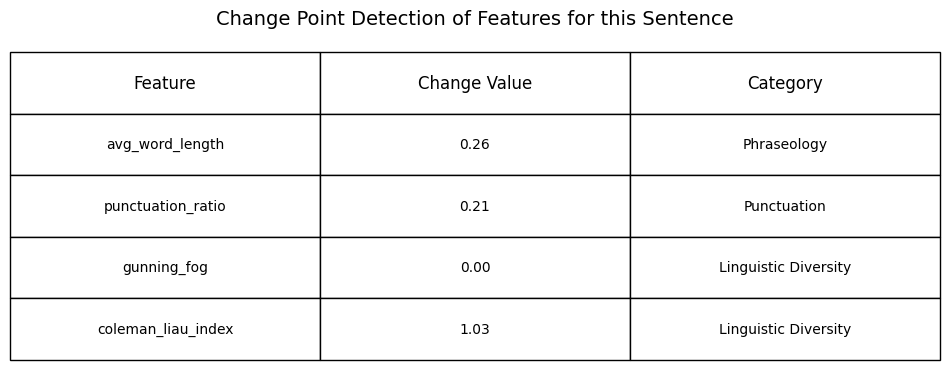

Change detected in sentence: “Silence in the face of injustice is complicity.
Feature changes:


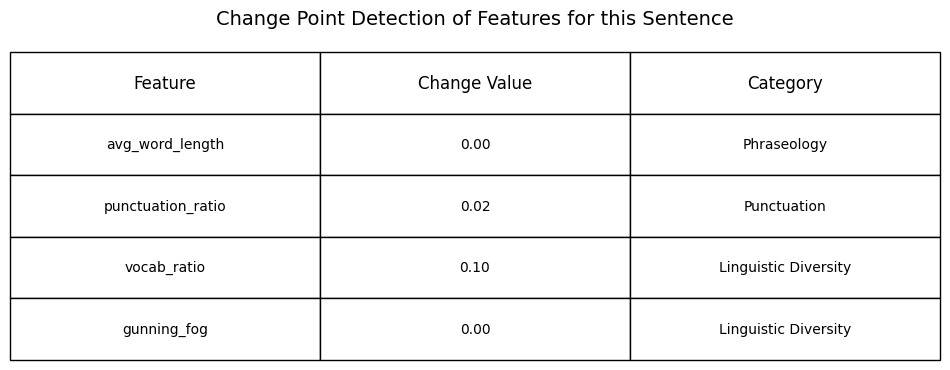

Change detected in sentence: Remember the Martin Neimoller quote from Germany?
Feature changes:


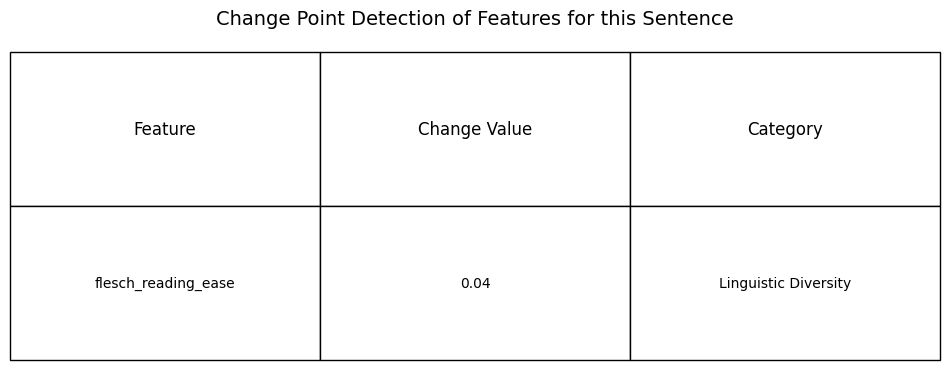

Change detected in sentence: Here’s our Philippine version, published by our largest newspaper after my first arrest: ‘First they came for the journalists.
Feature changes:


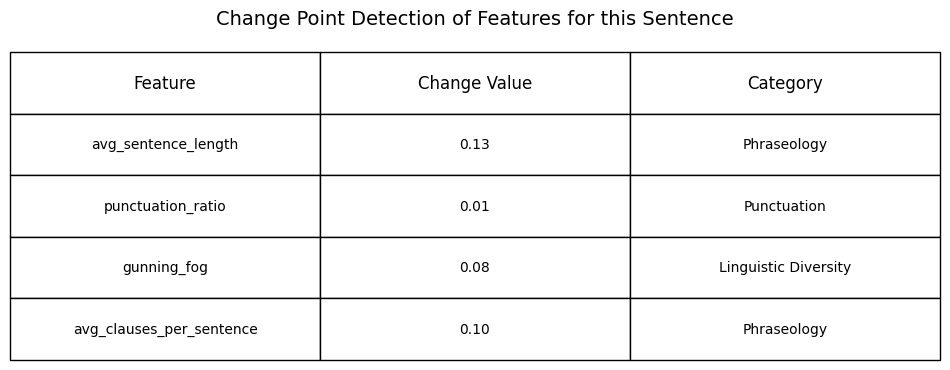

Change detected in sentence: We don’t know what happened next.’ Your networks can be powerful shields for marginalized communities.
Feature changes:


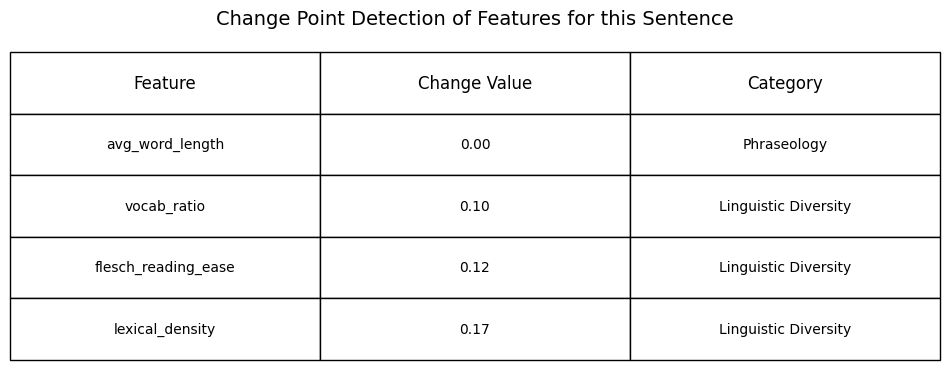

Change detected in sentence: Support immigrants, religious minorities, the LGBTQ+, and others who face discrimination.
Feature changes:


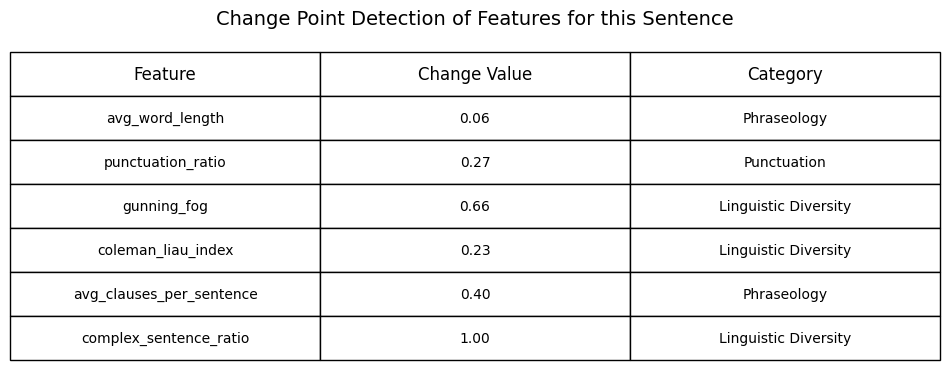

Change detected in sentence: Our collective vigilance can prevent the normalization of hate.”
Recognize your power.
Feature changes:


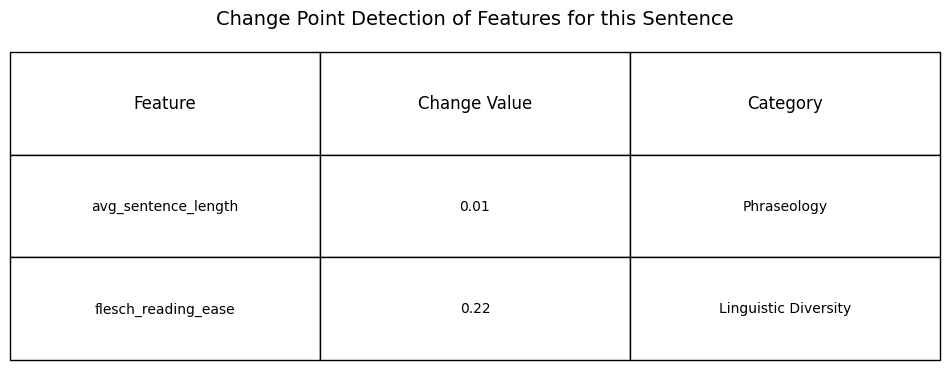

Change detected in sentence: You are powerful and can be part of a tidal wave of change for the good.
Feature changes:


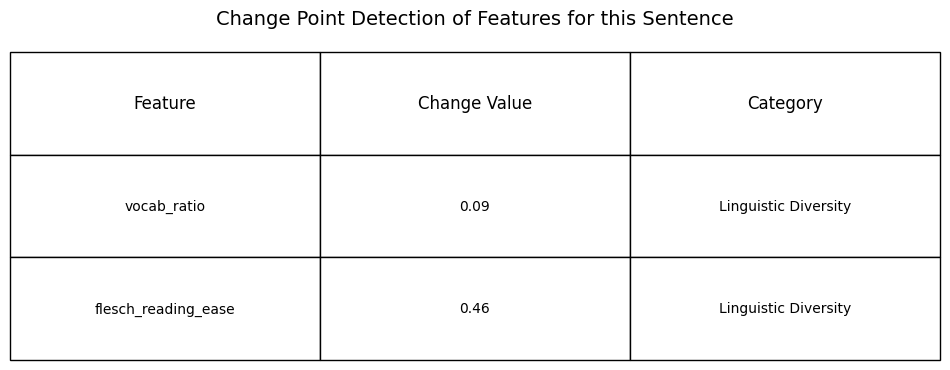

Change detected in sentence: And that is powered by love.”
“This time matters.
Feature changes:


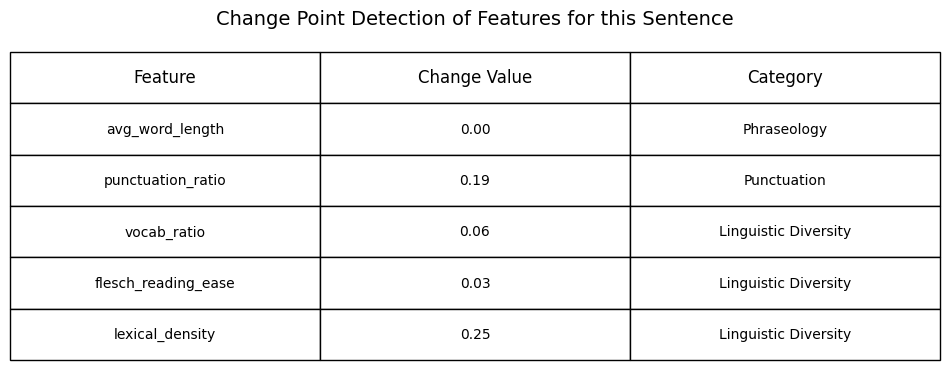

Change detected in sentence: – Rappler.com
Feature changes:


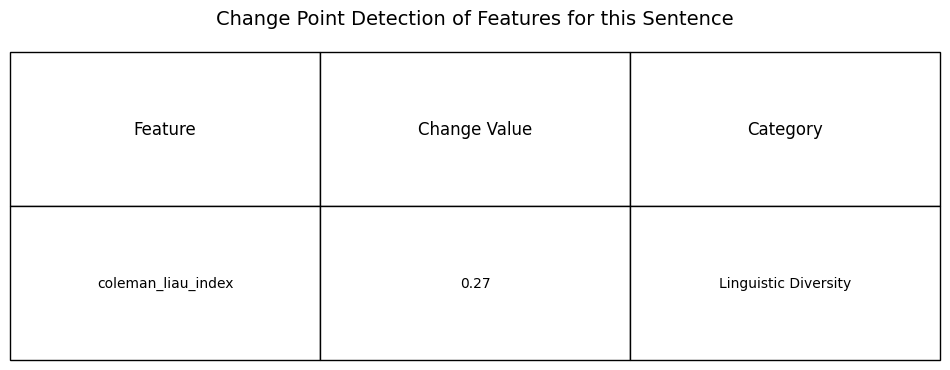


Changepoint Detection DataFrame:


Sentence Index                                           Sentence              Feature  Change Value              Category
0                1  Ressa, chief executive officer of Rappler, was...      avg_word_length      0.000000           Phraseology
1                1  Ressa, chief executive officer of Rappler, was...          vocab_ratio      0.012821  Linguistic Diversity
2                1  Ressa, chief executive officer of Rappler, was...   coleman_liau_index      0.000000  Linguistic Diversity
3                2  The other speaker was Irish journalist Colum M...      avg_word_length      0.000000           Phraseology
4                2  The other speaker was Irish journalist Colum M...    punctuation_ratio      0.009615           Punctuation
..             ...                                                ...                  ...           ...                   ...
86              33  And that is powered by love.”\n“This time matt...    punctuation_ratio      0.187500           Punctuation
87              33  And that is powered by love.”\n“This time matt...          vocab_ratio      0.062500  Linguistic Diversity
88              33  And that is powered by love.”\n“This time matt...  flesch_reading_ease      0.032100  Linguistic Diversity
89              33  And that is powered by love.”\n“This time matt...      lexical_density      0.250000  Linguistic Diversity
90              35                                      – Rappler.com   coleman_liau_index      0.274167  Linguistic Diversity

[91 rows x 5 columns]


--- Detailed Explanations of Changepoints ---
Change detected in sentence: Ressa, chief executive officer of Rappler, was a keynote speaker at the Jubilee of the World of Communications organized by the Vatican’s Dicastery for Communication.
Feature changes:
  Feature: avg_word_length, Change Value: 0.0000, Category: Phraseology
  Feature: vocab_ratio, Change Value: 0.0128, Category: Linguistic Diversity
  Feature: coleman_liau_index, Change Value: 0.0000, Category: Linguistic Diversity

--------------------------------------------------------------------------------

Change detected in sentence: The other speaker was Irish journalist Colum McCann.
Feature changes:
  Feature: avg_word_length, Change Value: 0.0000, Category: Phraseology
  Feature: punctuation_ratio, Change Value: 0.0096, Category: Punctuation
  Feature: vocab_ratio, Change Value: 0.1538, Category: Linguistic Diversity
  Feature: flesch_reading_ease, Change Value: 0.5110, Category: Linguistic Diversity
  Feature: lexica

In [62]:
new_text = """On the same platform from which the Pope delivers his weekly speeches, Rappler CEO Maria Ressa says the tech giants' unchecked power 'is resembling a cult'
VATICAN CITY – Nobel Peace Prize laureate Maria Ressa spoke at a major Vatican event on Saturday, January 25, and challenged world religions to work together in the face of rising autocracy by governments and Big Tech.

Ressa, chief executive officer of Rappler, was a keynote speaker at the Jubilee of the World of Communications organized by the Vatican’s Dicastery for Communication. The other speaker was Irish journalist Colum McCann.

“Even at the worst of times, hope is not passive; it is active, relentless, and strategic. Our faith traditions carry centuries of resilience; we need to share those stories of transformation,” Ressa said.

“Imagine if we all worked together. We just might stem the tide, stop the dam from falling, and heal our world,” said the 61-year-old Filipino-American journalist.

The crowd — composed of thousands of Catholic communicators around the world — gave her a standing ovation.

Saturday’s event was held at the Vatican’s 6,300-seater Paul VI Audience Hall, the iconic venue for Pope Francis‘ indoor general audiences.

The stage used by Ressa, a former CNN bureau chief, was the same platform from which the 88-year-old Argentine Pope delivers his Wednesday address.

Standing at 5 feet and 2 inches, Ressa addressed the crowd against the backdrop of a renowned bronze sculpture of Jesus — 66 feet wide and 23 feet tall — inspired by the atomic bombing of Hiroshima, Japan, in 1945. Titled “Resurrection” and inaugurated nearly 50 years ago, the sculpture resembles an explosion and symbolizes Christ’s victory over death.

Ressa recalled the Hiroshima bombing in her speech on Saturday in the context of how “new technology enabled the rise of fascism.”

“For many years now, I’ve sounded the alarm: just like in Hiroshima, an atom bomb exploded in our information ecosystem,” she said.


“In pursuit of power and money, technology enabled insidious manipulation at the cellular level of all of our democracies: of us — the voters — microtargeting fear, anger, and hate; seeding metanarratives that destroyed trust,” she said.

She remembered telling Pope Francis that the way technology “rewards lies” is against the Ten Commandments.

“The men who control this transformative technology wield godlike power, but they’re far from God. They’re only men, whose arrogance, lack of wisdom, and lack of humility is taking the world down a dark path. Increasingly, by their own words and definition, their unchecked and unaccountable power is resembling a cult,” Ressa said.

“Which is why religion, faith, the Catholic church, becomes more important today,” she added.

Ressa offered four suggestions:

Collaborate, collaborate, collaborate. “Build and strengthen trust now to close the fracture lines of society that information operations will try to pound open, pitting…each [of] us against the other.”
Speak truth with moral clarity. “Silence in the face of injustice is complicity. Whether it’s systemic racism, economic inequality, or the erosion of democratic norms, people of faith must reclaim — you must reclaim — their prophetic voice. Demand transparency and accountability from those who control our public information ecosystems — from governments to Big Tech to media.”
Protect the most vulnerable. “Support journalists, human rights defenders, and activists who risk their lives. Remember the Martin Neimoller quote from Germany? Here’s our Philippine version, published by our largest newspaper after my first arrest: ‘First they came for the journalists. We don’t know what happened next.’ Your networks can be powerful shields for marginalized communities. Support immigrants, religious minorities, the LGBTQ+, and others who face discrimination. Our collective vigilance can prevent the normalization of hate.”
Recognize your power. “Building peace is not reserved for heroes; it’s the collective work of people who refuse to accept and live lies. Rappler could not have survived without the help of our community, always reminding me of the goodness of human nature. You are powerful and can be part of a tidal wave of change for the good. And that is powered by love.”
“This time matters. What you choose to do matters,” Ressa said. – Rappler.com"""
author = "Maria A. Ressa"
#thresholds = [0.5, 5, 0.02, 0.05, 5, 2, 1, 2]
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")
#changepoints, explanations = detect_change_points_in_text(new_text, author, clf)

# Detect changepoints, explanations, and changepoint DataFrame
changepoints, explanations, changepoint_df = detect_change_points_in_text(new_text, author, clf)

# Display options for pandas to prevent compression issues
pd.set_option('display.max_rows', 20)  # Show up to 20 rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust column width

# Display the changepoint DataFrame
print("\nChangepoint Detection DataFrame:")
display(changepoint_df)

# Display the same results as before using explanations
print("\n--- Detailed Explanations of Changepoints ---")
for explanation in explanations:
    print(f"Change detected in sentence: {explanation['sentence']}")
    print("Feature changes:")
    for feature_change in explanation['feature_changes']:
        print(f"  Feature: {feature_change['Feature']}, Change Value: {feature_change['Change Value']:.4f}, Category: {feature_change['Category']}")
    print("\n" + "-" * 80 + "\n")  # Add a separator line and a blank line